In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import scipy

from sklearn.decomposition import PCA

from utils.depth_camera import DepthCamera

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [102]:
data_dir = "data/raw_data"
experiment = "exp_8"
trial = "trial_2"
subject = "subject-1"
sequence = 2

file_name = f"{experiment}__{trial}__{subject}__{sequence:02d}"
pose_file = os.path.join("data/trajectories/groundtruth", experiment, f"{file_name}.pose.npz")

motion_dir = os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "motion")

In [103]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000
print(f"Frame rate: {frame_rate:.2f} Hz")

Frame rate: 400.91 Hz


### Low-pass filter

In [45]:
# Low pass filter
alpha = 0.8
gravity = [0, 0, 0]
# only for analysis
gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

for i in tqdm.trange(imu_df.shape[0]):
    for j in range(3):
        gravity[j] = alpha * gravity[j] + (1 - alpha) * imu_df.iloc[i, 1 + j]
        imu_df.iloc[i, 1 + j] = imu_df.iloc[i, 1 + j] - gravity[j]
    
    gravity_df = pd.concat([gravity_df, pd.DataFrame({"timestamp": [imu_df.iloc[i, 0]], "x": [gravity[0]], "y": [gravity[1]], "z": [gravity[2]]})], ignore_index=True)

100%|██████████| 8019/8019 [00:04<00:00, 1788.57it/s]


<AxesSubplot:title={'center':'Gravity'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

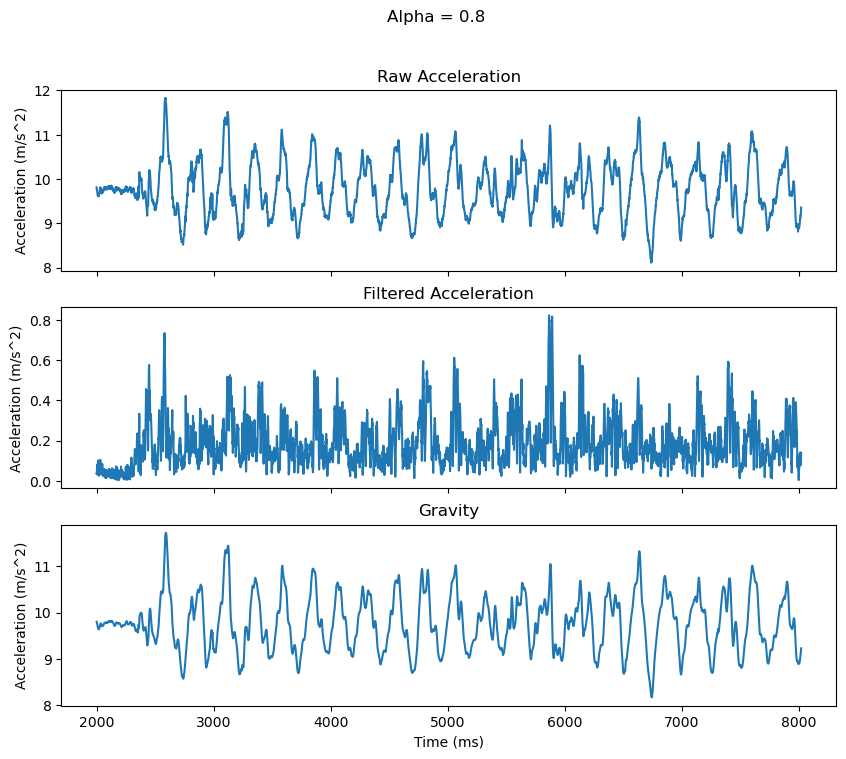

In [49]:
figure, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")

raw_accel_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])
gravity_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["x", "y", "z"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Gravity", ax=axes[2])

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

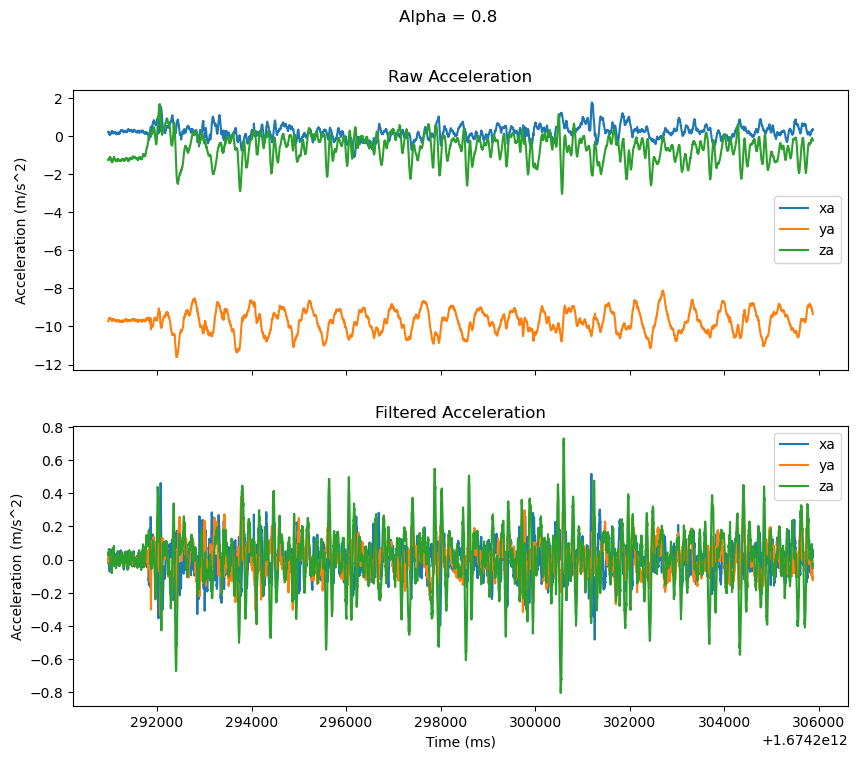

In [50]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")
raw_accel_df.iloc[2000:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[2000:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [34]:
# remove nan values due to rolling mean
imu_df = imu_df.iloc[2000:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [35]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 6017/6017 [00:01<00:00, 3499.81it/s]


In [36]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  0.08915088989534294
GT Distance:  10.118946802419455


### Moving average filter

In [93]:
win_len = int(frame_rate * 4)

accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

<AxesSubplot:title={'center':'Gravity'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

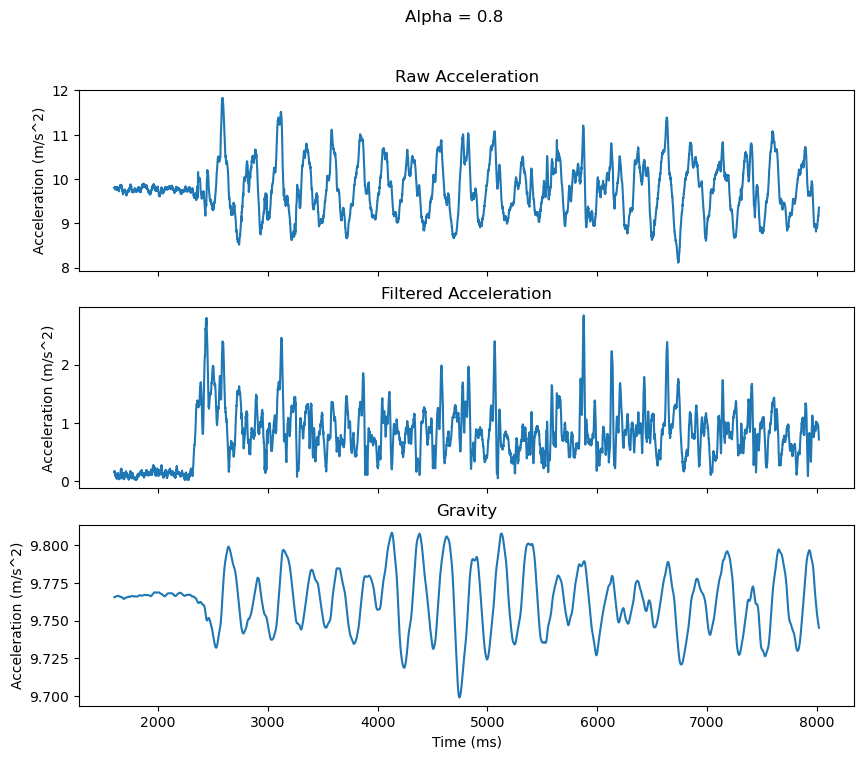

In [94]:
figure, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")

raw_accel_df.iloc[win_len:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[win_len:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])
accel_mavg.iloc[win_len:].apply(lambda x: np.linalg.norm(x[:3]), axis=1).plot(x="timestamp", y=["x", "y", "z"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Gravity", ax=axes[2])

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

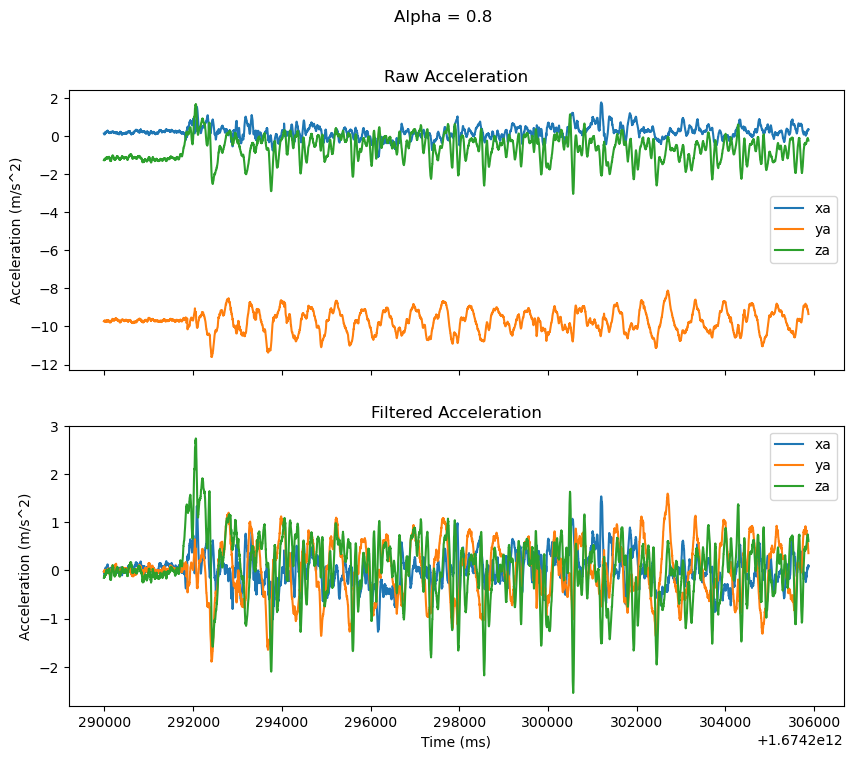

In [95]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")
raw_accel_df.iloc[win_len:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[win_len:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [96]:
# remove nan values due to rolling mean
imu_df = imu_df.iloc[win_len:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [97]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 6414/6414 [00:02<00:00, 3022.02it/s]


In [98]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  11.454788621944491
GT Distance:  10.158485928655006


In [99]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

### Orientation tracking

In [104]:
win_len = int(frame_rate * 3)

gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values

In [105]:
imu_df = imu_df.iloc[win_len:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [106]:
accel_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

In [107]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values
    acceleration = np.dot(rotation_matrix, np.array([*acceleration, 1]))
    acceleration = acceleration[:3] - gravity
    
    accel_df = pd.concat([accel_df, pd.DataFrame([[v[0], *acceleration]], columns=["timestamp", "x", "y", "z"])])
    
    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    
    # d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]

100%|██████████| 6815/6815 [00:06<00:00, 1126.71it/s]


In [112]:
accel_df.apply(lambda x: np.linalg.norm(x[1:4]), axis=1)

0    0.050518
0    0.056932
0    0.060599
0    0.084375
0    0.092347
       ...   
0    0.625534
0    0.570440
0    0.541938
0    0.500256
0    0.453150
Length: 6815, dtype: float64

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

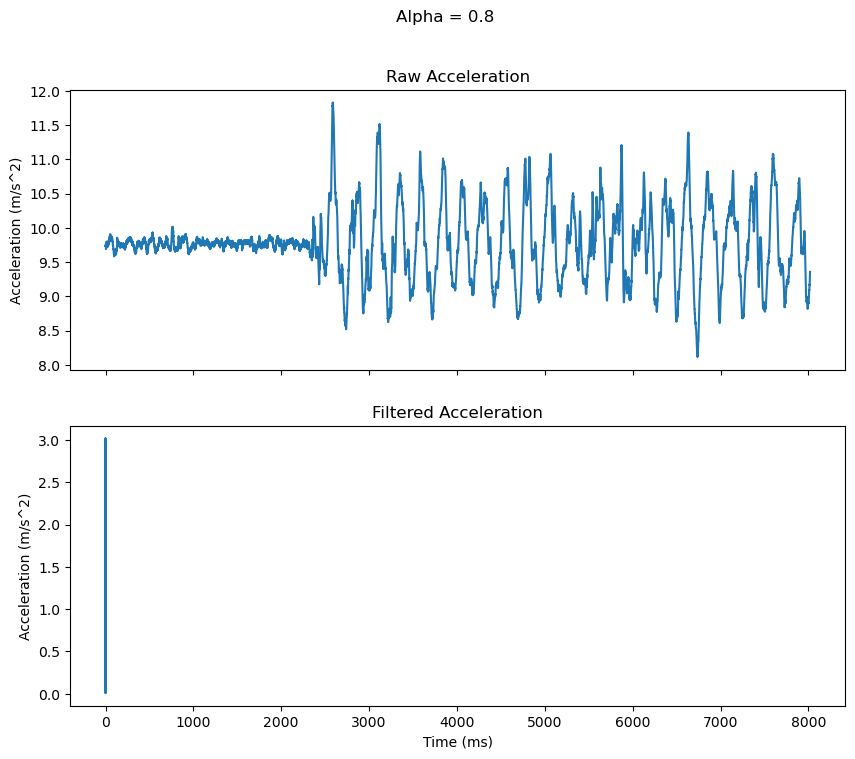

In [114]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")

raw_accel_df.apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
accel_df.apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [89]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  13.843080426190435
GT Distance:  10.169556351110685


In [100]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

In [26]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    # current displacement and rotation
    omega_squared = np.sum(np.square(np.degrees(v[4:7])))
    
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values
    acceleration = -omega_squared * np.dot(rotation_matrix, np.array([*acceleration, 1]))
    acceleration = acceleration[:3] - gravity
    
    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]

100%|██████████| 6414/6414 [00:02<00:00, 2453.19it/s]


In [22]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    # current displacement and rotation
    w_local = [v[j + 4] for j in range(3)]
    a_local = [v[j + 1] for j in range(3)]
    
    ω_global = np.matmul(rotation_matrix, np.array([*w_local, 1]))
    v_global = np.matmul(rotation_matrix, np.array([*velocity, 1]))
    a_global = 2 * np.cross(ω_global[:3], velocity) + np.matmul(rotation_matrix, np.array([*a_local, 1]))[:3]
    
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    # acceleration = imu_df.iloc[i, [1, 2, 3]].values
    # acceleration = np.dot(rotation_matrix, np.array([*acceleration, 1]))
    # acceleration = acceleration[:3] - gravity
    acceleration = a_global - gravity
    
    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    
    # d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]

100%|██████████| 6414/6414 [00:02<00:00, 2987.23it/s]


In [147]:
acceleration = imu_df.iloc[1300, [1, 2, 3]].values

In [18]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values
    acceleration = np.dot(rotation_matrix, np.array([*acceleration, 1]))
    acceleration = acceleration[:3] - gravity
    
    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    
    # d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]

100%|██████████| 6414/6414 [00:02<00:00, 2628.22it/s]


In [27]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

PointCloud with 6415 points.

In [20]:
file_name = f"{experiment}__{trial}__{subject}__{sequence:02d}"
pose_file = os.path.join("data/trajectories/groundtruth", experiment, f"{file_name}.pose.npz")
trajectory_t = np.load(pose_file)["trajectory_t"]

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])

PointCloud with 421 points.

In [28]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

In [ ]:
# Low pass filter
alpha = 0.1
gravity = [0, 0, 0]

for i in tqdm.trange(imu_df.shape[0]):
    for j in range(3):
        gravity[j] = alpha * gravity[j] + (1 - alpha) * imu_df.iloc[i, 1 + j]
        imu_df.iloc[i, 1 + j] = imu_df.iloc[i, 1 + j] - gravity[j]
    
    gravity_df = pd.concat([gravity_df, pd.DataFrame({"timestamp": [imu_df.iloc[i, 0]], "x": [gravity[0]], "y": [gravity[1]], "z": [gravity[2]]})], ignore_index=True)

In [183]:
accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=2000).mean()
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

# imu_df.dropna(inplace=True)
# imu_df.reset_index(drop=True, inplace=True)

# accel_mavg.loc[:, "r"] = accel_mavg.apply(lambda row: np.linalg.norm(row[["xa", "ya", "za"]]), axis=1)

In [11]:
gravity_df.loc[:, "r"] = gravity_df.apply(lambda row: np.linalg.norm(row[["x", "y", "z"]]), axis=1)

In [30]:
gravity_df_all = gravity_df.copy()
gravity_df_all.drop(["x", "y", "z"], axis=1, inplace=True)

In [43]:
gravity_df_all.loc[:, "0.8"] = gravity_df.loc[:, "r"]

<AxesSubplot:xlabel='timestamp'>

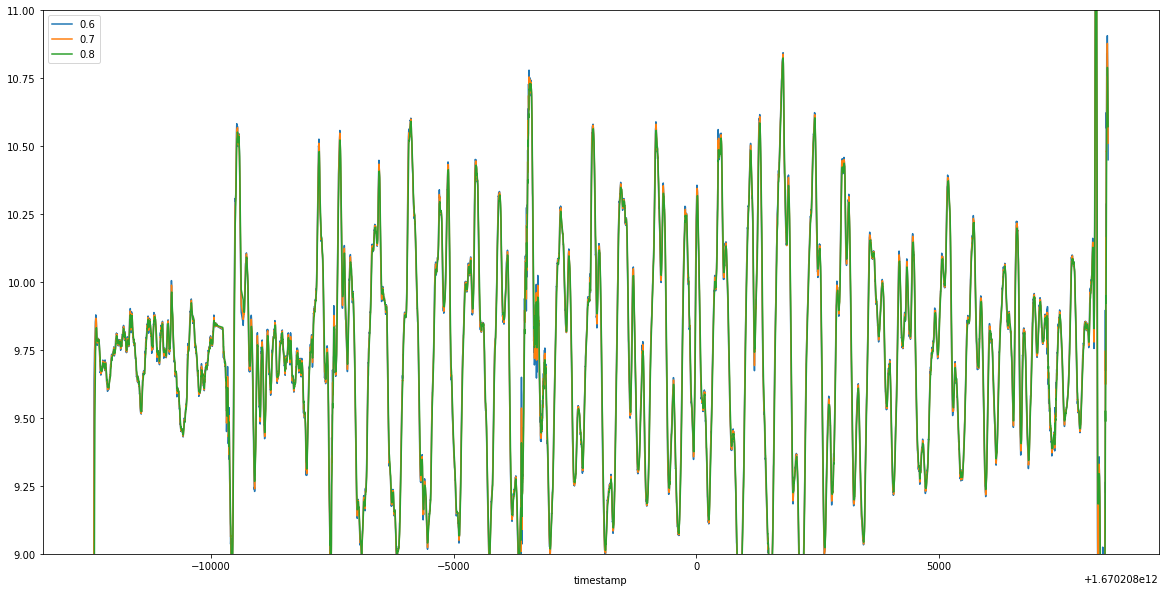

In [44]:
gravity_df_all.plot(x="timestamp", ylim=(9, 11), figsize=(20, 10))

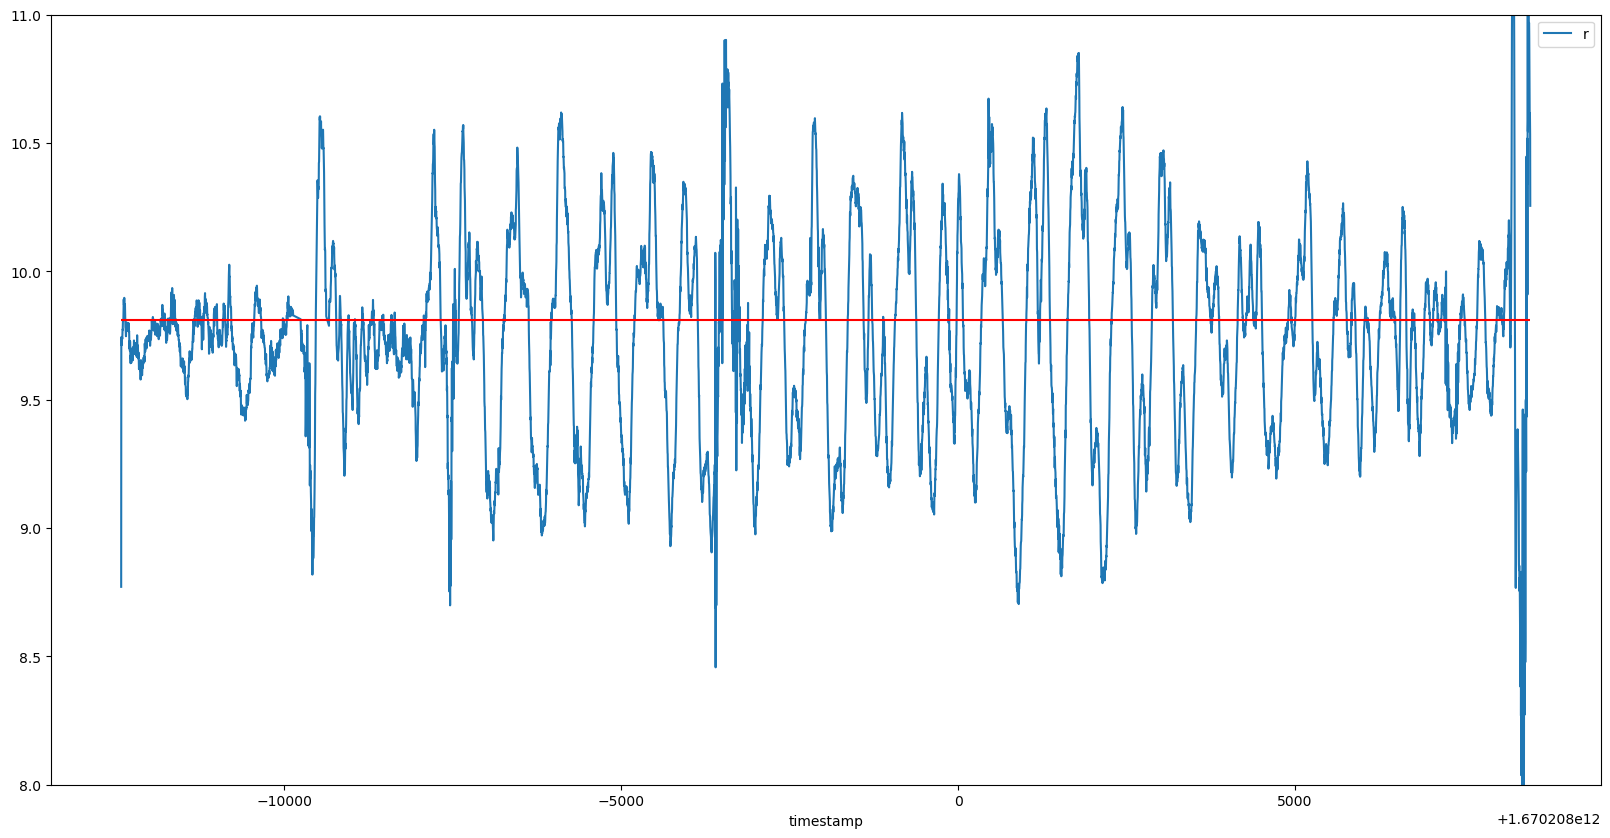

In [12]:
plot = gravity_df.plot(x="timestamp", y="r", ylim=(8, 11), figsize=(20, 10))
plot.hlines(9.81, gravity_df.timestamp.values[0], gravity_df.timestamp.values[-1], colors="red")

Text(0, 0.5, 'Acceleration (m/s^2)')

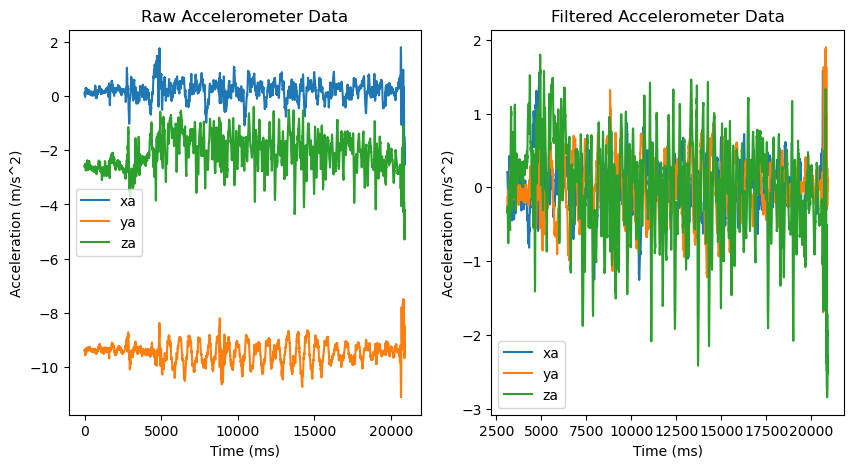

In [137]:
filtered_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

filtered_accel_df.loc[:, "timestamp"] = filtered_accel_df.timestamp.values - filtered_accel_df.timestamp.values[0]
raw_accel_df.loc[:, "timestamp"] = raw_accel_df.timestamp.values - raw_accel_df.timestamp.values[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

raw_accel_df.set_index("timestamp").loc[:, ["xa", "ya", "za"]].plot(ax=axes[0])
filtered_accel_df.set_index("timestamp").loc[:, ["xa", "ya", "za"]].plot(ax=axes[1])

axes[0].set_title("Raw Accelerometer Data")
axes[1].set_title("Filtered Accelerometer Data")

axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")

axes[0].set_ylabel("Acceleration (m/s^2)")
axes[1].set_ylabel("Acceleration (m/s^2)")

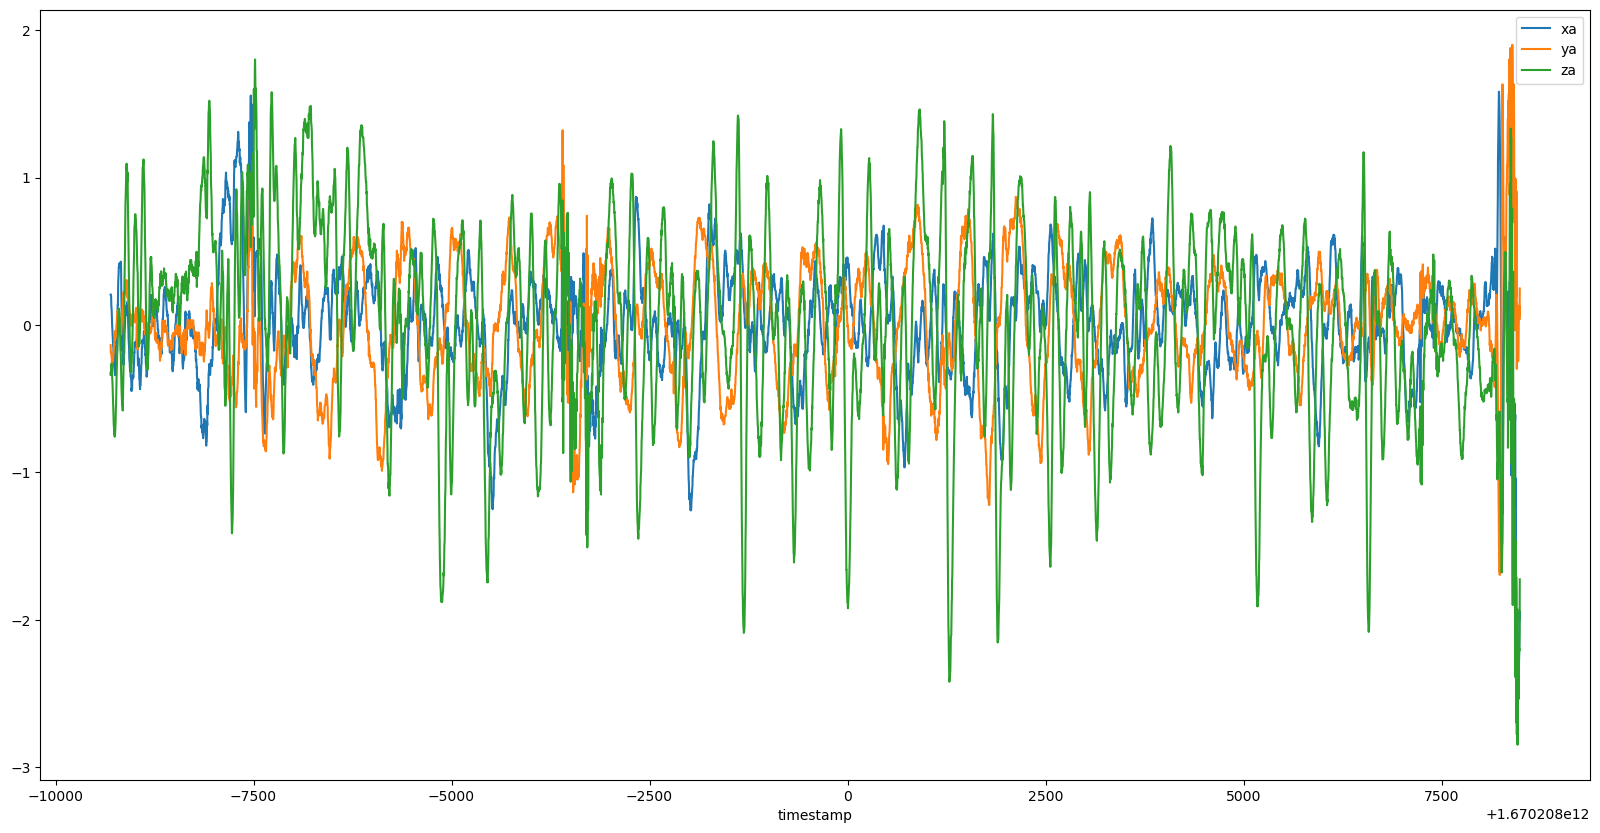

In [141]:
plot = imu_df.plot(x="timestamp", y=["xa", "ya", "za"], figsize=(20, 10))
# plot.hlines(-9.81, imu_df.timestamp.values[0], imu_df.timestamp.values[-1], colors="red")

In [123]:
raw_accel_df.loc[:, "r"] = raw_accel_df.apply(lambda row: max(0, np.linalg.norm(row[["xa", "ya", "za"]]) - 9.81), axis=1)

In [126]:
raw_accel_df.loc[:, "dt"] = np.concatenate([[0], (raw_accel_df.timestamp.values[1:] - raw_accel_df.timestamp.values[:-1]) / 1000])

In [127]:
raw_accel_df

,timestamp,xa,ya,za,r,dt
0,1.670208e+12,0.062030,-9.400411,-2.570001,0.000000,0.000
1,1.670208e+12,0.081685,-9.419782,-2.569731,0.000000,0.001
2,1.670208e+12,0.093232,-9.389303,-2.628013,0.000000,0.001
3,1.670208e+12,0.092560,-9.389657,-2.598429,0.000000,0.001
4,1.670208e+12,0.143216,-9.348952,-2.625650,0.000000,0.001
...,...,...,...,...,...,...
8367,1.670208e+12,-2.071559,-9.266627,-4.738589,0.802067,0.004
8368,1.670208e+12,-2.013505,-9.256516,-4.667437,0.750410,0.002
8369,1.670208e+12,-1.845334,-9.351890,-4.683551,0.810675,0.002
8370,1.670208e+12,-1.768050,-9.312299,-4.571747,0.713582,0.003


In [128]:
velocity = 0
distance = 0

for i in tqdm.trange(len(raw_accel_df)):
    v = raw_accel_df.iloc[i].values
    dt = v[5]
    distance = distance + (velocity * dt) + (0.5 * v[4] * dt * dt)
    velocity = velocity + v[1] * dt

100%|██████████| 8372/8372 [00:00<00:00, 15623.99it/s]


In [129]:
distance

45.33573457637663

In [184]:
# remove first second's data (as it stabilizes the gravity)
# imu_df = imu_df.iloc[400:]
imu_df.dropna(inplace=True)
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='timestamp'>

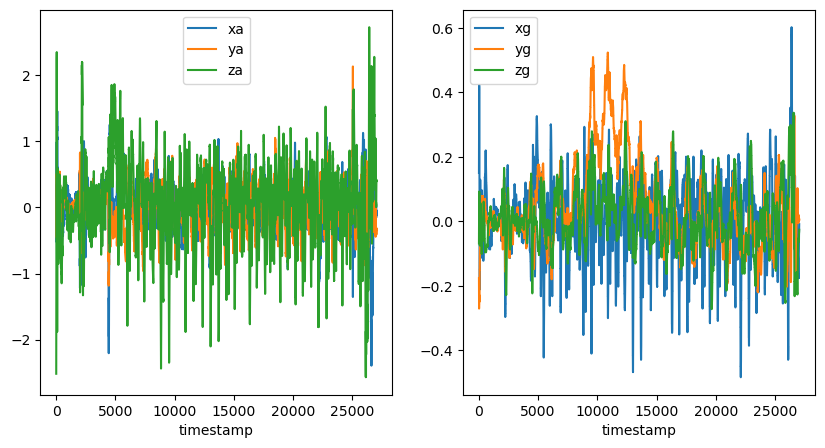

In [185]:
plot_df = imu_df.copy()
plot_df.loc[:, "timestamp"] = plot_df.timestamp.values - plot_df.timestamp.values[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plot_df.set_index("timestamp").loc[:, ["xa", "ya", "za"]].plot(ax=axes[0])
plot_df.set_index("timestamp").loc[:, ["xg", "yg", "zg"]].plot(ax=axes[1])

In [186]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [187]:
velocity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

In [188]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in tqdm.trange(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt
        
    velocity_df = pd.concat([velocity_df, pd.DataFrame([[imu[0], velocity[0], velocity[1], velocity[2]]], columns=["timestamp", "x", "y", "z"])])

100%|██████████| 10907/10907 [00:07<00:00, 1413.84it/s]


In [189]:
velocity_df.loc[:, "r"] = velocity_df.apply(lambda row: np.linalg.norm(row[["x", "y", "z"]]), axis=1)

<AxesSubplot:xlabel='timestamp'>

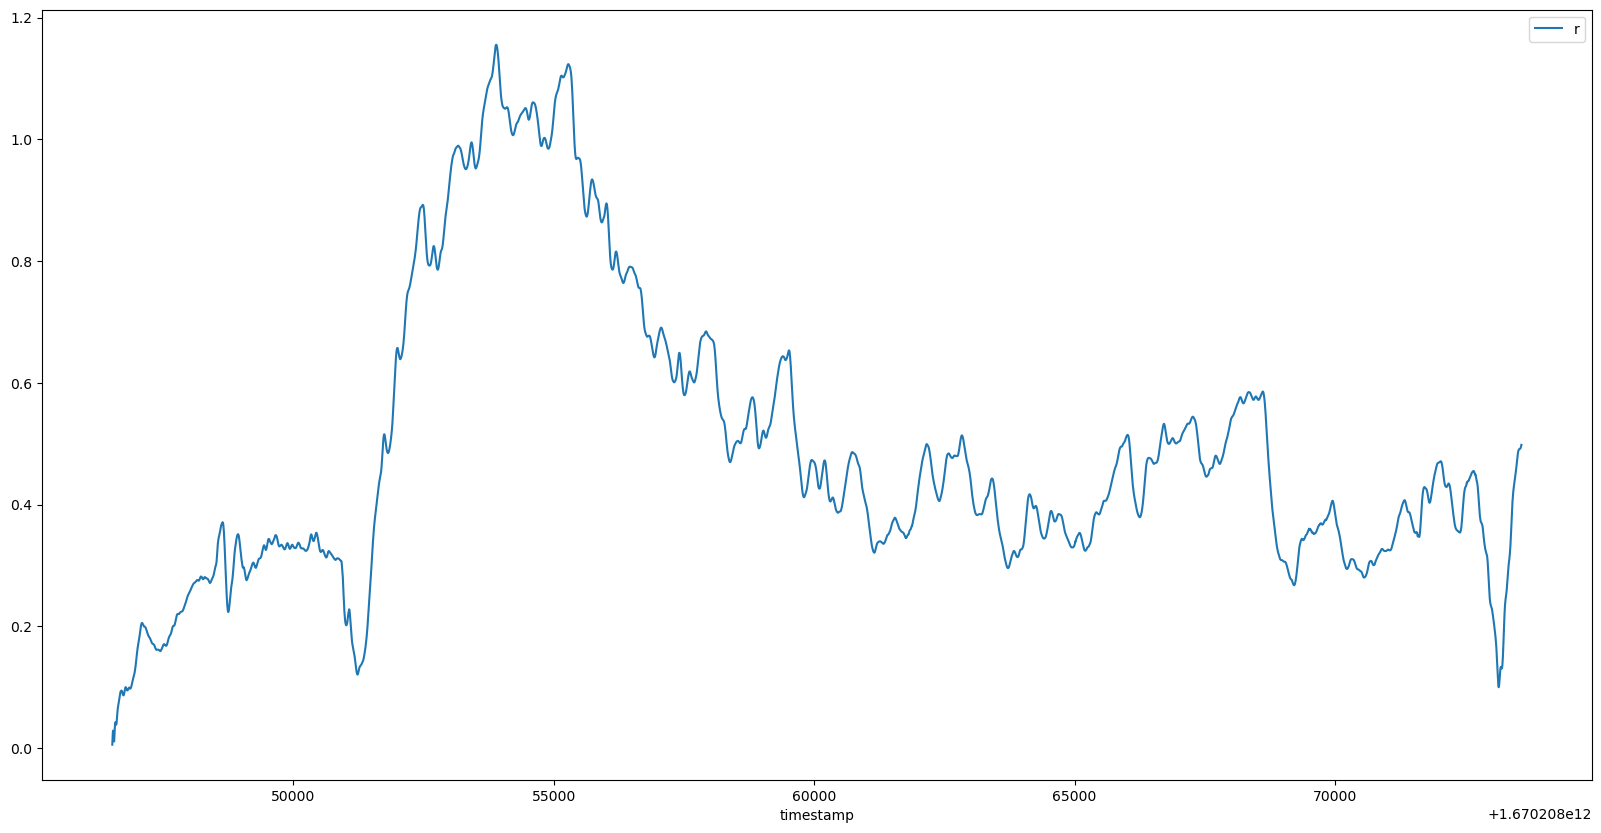

In [190]:
velocity_df.plot(x="timestamp", y="r", figsize=(20, 10))

In [93]:
duration = imu_df.timestamp.values[-1] - imu_df.timestamp.values[0]
print("Duration: {} ms".format(duration))
print("Distance: {} m".format(duration * 0.03 / 1000))

Duration: 18933.0 ms
Distance: 0.56799 m


In [191]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [192]:
for i in tqdm.tqdm(range(1, len(imu_df))):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

100%|██████████| 10906/10906 [00:02<00:00, 3802.14it/s]


In [193]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

PointCloud with 10907 points.

In [194]:
np.linalg.norm(xyz[-1])

7.541114784976693

In [195]:
open3d.visualization.draw_geometries([pcd])

In [63]:
file_name = f"{experiment}__{trial}__{subject}__{sequence:02d}"
pose_file = os.path.join("data/trajectories/groundtruth", experiment, f"{file_name}.pose.npz")
trajectory_t = np.load(pose_file)["trajectory_t"]

pcd_gt = helpers.make_pcd(trajectory_t[:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])

In [65]:
open3d.visualization.draw_geometries([pcd_gt, pcd])

In [65]:
np.linalg.norm(trajectory_t[-1, :3, 3])

9.345717843359145

Experiment to check integration with simulated data

In [78]:
imu = [[2] for _ in range(2000)] + [[0] for _ in range(3000)] + [[-2] for _ in range(2000)]
timestamps = [[i] for i in range(7000)]

data = np.concatenate([timestamps, imu], axis=1)

accel_df = pd.DataFrame(data, columns=["timestamp", "x"])

In [79]:
# accel_df.loc[:, "dt"] = (accel_df.timestamp.values - accel_df.timestamp.values[0]) / 1000
accel_df.loc[:, "dt"] = np.concatenate([[0], (accel_df.timestamp.values[1:] - accel_df.timestamp.values[:-1]) / 1000])
# remove first row
accel_df = accel_df.iloc[1:]

In [80]:
accel_df.loc[:, "dx"] = np.zeros(len(accel_df))

In [76]:
accel_df.values[10]

array([1.2e+01, 2.0e+00, 1.0e-03])

In [84]:
velocity = 0
distance = 0

for i in tqdm.trange(len(accel_df)):
    v = accel_df.iloc[i].values
    dt = v[2]
    distance = distance + (velocity * dt) + (0.5 * v[1] * dt * dt)
    accel_df.iloc[i, 3] = distance
    velocity = velocity + v[1] * dt

100%|██████████| 6999/6999 [00:01<00:00, 5301.51it/s]


<AxesSubplot:xlabel='timestamp'>

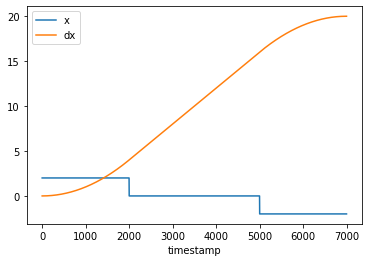

In [85]:
accel_df.set_index("timestamp").loc[:, ["x", "dx"]].plot()

In [ ]:
d = 0.5 * 2 * 4 + 4 * 3 + 0.5 * 4 * 2
print(f"Total distance: {d}")

Linear acceleration from Android API

In [105]:
accel_df = pd.read_csv("data/android/1673931013121/acceleration.csv", names=["timestamp", "x", "y", "z"])
gyro_df = pd.read_csv("data/android/1673931013121/gyroscope.csv", names=["timestamp", "x", "y", "z"])

In [106]:
accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

<AxesSubplot:xlabel='timestamp'>

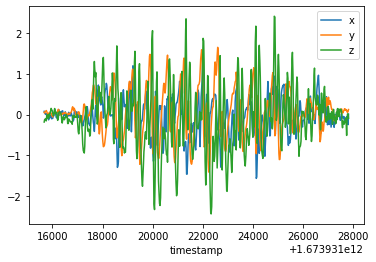

In [107]:
accel_df.loc[125:, ["timestamp", "x", "y", "z"]].set_index("timestamp").plot()

In [108]:
accel_df = accel_df.iloc[125:]

accel_df.loc[:, "gyro_t"] = accel_df.apply(lambda x: nearest(gyro_df.timestamp.values, x.timestamp), axis=1)

imu_df = pd.merge(
    accel_df.loc[:, ["gyro_t", "x", "y", "z"]],
    gyro_df.loc[:, ["timestamp", "x", "y", "z"]],
    left_on="gyro_t",
    right_on="timestamp",
    suffixes=("a", "g")
)

imu_df.drop("gyro_t", axis=1, inplace=True)
imu_df = imu_df.loc[:, ["timestamp", "xa", "ya", "za", "xg", "yg", "zg"]]

In [109]:
# remove first second's data (as it stabilizes the gravity)
# imu_df = imu_df.iloc[400:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

In [110]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [111]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in range(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        # imu_df.iloc[i, 11 + j] = imu[j + 4] * dt
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt

In [112]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [113]:
for i in range(1, len(imu_df)):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

In [114]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

open3d.visualization.draw_geometries([pcd])

In [115]:
np.linalg.norm(xyz[-1])

8.289169564567784